In [1]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Libraries for the project

In [2]:
import pandas as pd
import cv2
import os
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
import keras
from keras.losses import CategoricalCrossentropy
from keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from skimage.feature import local_binary_pattern
import skimage.feature
from tensorflow.keras import models, layers
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import efficientnet.tfkeras as efn
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load the data

In [3]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Dataset_2/data.csv')

# Display the first 5 rows of the DataFrame
# df.head()


In [4]:
# Drop the "Unnamed: 0" column
df = df.drop(columns=['Unnamed: 0'])

# Reset the index
df = df.reset_index(drop=True)

# Display the updated DataFrame
# print(df)

In [5]:
# Select rows where the "classes" column contains "unknown"
df = df[df['classes'] != 'unknown']

In [6]:
df.shape

(1045, 2)

In [7]:
# Count the number of occurrences of each value in the "classes" column
class_counts = df['classes'].value_counts()

# Display the class counts
print(class_counts)

door_dent         192
bumper_scratch    164
door_scratch      154
glass_shatter     137
tail_lamp         136
head_lamp         133
bumper_dent       129
Name: classes, dtype: int64


In [8]:
# Use the factorize() method to convert categorical values to numerical values
df['classes'] = pd.factorize(df['classes'])[0]

# Display the updated DataFrame
df.head()

,image,classes
1,image/1.jpeg,0
2,image/2.jpeg,1
3,image/3.jpeg,0
6,image/6.jpeg,2
8,image/8.jpeg,3


In [9]:
df.dtypes

image      object
classes     int64
dtype: object

# Preprocessing

In [10]:
img_path = 'Dataset_2/'
X = []
y = []
# Loop over the rows of the DataFrame and read the images
for index, row in df.iterrows():
    filename = row['image']
    if os.path.exists(img_path + filename):
        img = cv2.imread(os.path.join(img_path, filename))
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(row['classes'])
        

In [11]:
# Split data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=9)

# Split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/.85, random_state=9)

# Data Augmentation

In [12]:
# Define the data augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    zoom_range=0.2,  # Apply a random zoom to the image within a 20% range
    shear_range=0.2,  # Apply a random shear transformation to the image within a 20% range
    brightness_range=[0.5, 1.5],  # Adjust brightness by a random factor within a 50%-150% range
    fill_mode='nearest'  # Fill newly created pixels with the nearest available pixel
)


# Convert the input data and labels to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Apply the data augmentation transformations and append the augmented images and corresponding labels to the original data
augmented_X = []
augmented_y = []
for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    augmented_images = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)
    for j in range(10):
        augmented_X.append(augmented_images.next()[0])
        augmented_y.append(label)

# Concatenate the original data with the augmented data
X_train = np.concatenate((X_train, np.array(augmented_X)))
y_train = np.concatenate((y_train, np.array(augmented_y)))


In [13]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [14]:
#X_train = X_train.astype('float32') / 255.0
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(8041, 224, 224, 3) (8041,)
(157, 224, 224, 3) (157,)
(157, 224, 224, 3) (157,)


# Feature Extraction

In [15]:
# Define a function for applying the Sobel operator to an image
def apply_sobel_3c(image):
    # Split the image into its color channels
    b, g, r = cv2.split(image)
    
    # Apply the Sobel operator to each color channel
    gradient_x_b = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y_b = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag_b = np.sqrt(gradient_x_b ** 2 + gradient_y_b ** 2)
    
    gradient_x_g = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y_g = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag_g = np.sqrt(gradient_x_g ** 2 + gradient_y_g ** 2)
    
    gradient_x_r = cv2.Sobel(r, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y_r = cv2.Sobel(r, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag_r = np.sqrt(gradient_x_r ** 2 + gradient_y_r ** 2)
    
    # Combine the gradient magnitudes of each color channel
    gradient_mag = cv2.merge((gradient_mag_b, gradient_mag_g, gradient_mag_r))
    
    return gradient_mag


def apply_laplacian(image):
    # Split the image into its individual channels
    b, g, r = cv2.split(image)

    # Convert the channels to 8-bit format
    b = cv2.convertScaleAbs(b)
    g = cv2.convertScaleAbs(g)
    r = cv2.convertScaleAbs(r)

    # Apply the Laplacian edge detector to each channel separately
    b_lap = cv2.Laplacian(b, cv2.CV_64F)
    g_lap = cv2.Laplacian(g, cv2.CV_64F)
    r_lap = cv2.Laplacian(r, cv2.CV_64F)

    # Merge the Laplacian images of each channel
    laplacian = cv2.merge([b_lap, g_lap, r_lap])

    return laplacian


def apply_canny(image, min_threshold, max_threshold):
    # Convert the image to 8-bit unsigned integer
    img = cv2.convertScaleAbs(image)

    # Split the image into its 3 color channels
    b, g, r = cv2.split(img)

    # Apply Canny edge detection to each color channel
    b_edges = cv2.Canny(cv2.GaussianBlur(b, (3, 3), 0), min_threshold, max_threshold)
    g_edges = cv2.Canny(cv2.GaussianBlur(g, (3, 3), 0), min_threshold, max_threshold)
    r_edges = cv2.Canny(cv2.GaussianBlur(r, (3, 3), 0), min_threshold, max_threshold)

    # Merge the edge images back into a single image
    edges = cv2.merge([b_edges, g_edges, r_edges])

    return edges


def apply_harris(image, block_size, ksize, k):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the Harris corner response
    corners = cv2.cornerHarris(gray, block_size, ksize, k)

    # Normalize the corner response
    cv2.normalize(corners, corners, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    corners = np.uint8(corners)

    # Create a 3-channel image with the corner response in all channels
    corners_rgb = cv2.merge((corners, corners, corners))

    return corners_rgb

def apply_lbp(image):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale image to 8-bit unsigned integer
    gray = cv2.convertScaleAbs(gray)

    # Apply LBP with a radius of 1 and 8 neighboring pixels
    lbp = cv2.spatialGradient(gray, 8, cv2.CV_8U)

    # Extract the LBP values from the tuple
    lbp = lbp[0]

    # Split the LBP image into three channels
    channels = [np.zeros_like(lbp) for _ in range(3)]
    for i in range(3):
        channels[i][lbp >= 85 * i] = 1

    # Convert the channels to uint8
    for i in range(3):
        channels[i] = np.uint8(channels[i] * 255)

    # Merge the channels into a single image
    output = cv2.merge(channels)

    return output


In [16]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

# Laplacian Operator

In [17]:
# Apply the Laplacian edge detector to each image in the array
gradients_X_train = np.array([apply_laplacian(image) for image in X_train])
gradients_X_test = np.array([apply_laplacian(image) for image in X_test])
gradients_X_val = np.array([apply_laplacian(image) for image in X_val])
# 75%

# Basic CNN

Epoch 1/10
252/252 [==============================] - 9s 20ms/step - loss: 5.6648 - accuracy: 0.1822 - val_loss: 1.9410 - val_accuracy: 0.1847
Epoch 2/10
252/252 [==============================] - 5s 18ms/step - loss: 1.7434 - accuracy: 0.3166 - val_loss: 1.9436 - val_accuracy: 0.2166
Epoch 3/10
252/252 [==============================] - 5s 18ms/step - loss: 1.2016 - accuracy: 0.5533 - val_loss: 2.7997 - val_accuracy: 0.3057
Epoch 4/10
252/252 [==============================] - 5s 18ms/step - loss: 0.6497 - accuracy: 0.7703 - val_loss: 5.0415 - val_accuracy: 0.2994
Epoch 5/10
252/252 [==============================] - 5s 18ms/step - loss: 0.3235 - accuracy: 0.9070 - val_loss: 6.8566 - val_accuracy: 0.3439
Epoch 6/10
252/252 [==============================] - 5s 18ms/step - loss: 0.2052 - accuracy: 0.9484 - val_loss: 10.3861 - val_accuracy: 0.2548
Epoch 7/10
252/252 [==============================] - 5s 18ms/step - loss: 0.1734 - accuracy: 0.9628 - val_loss: 9.1173 - val_accuracy: 0.293

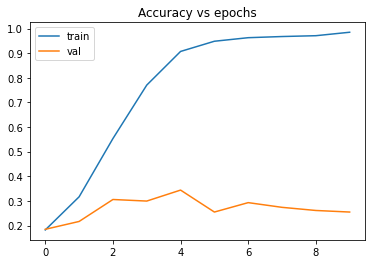

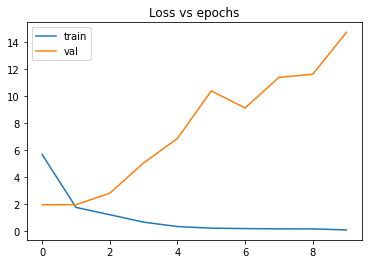

5/5 [==============================] - 0s 5ms/step


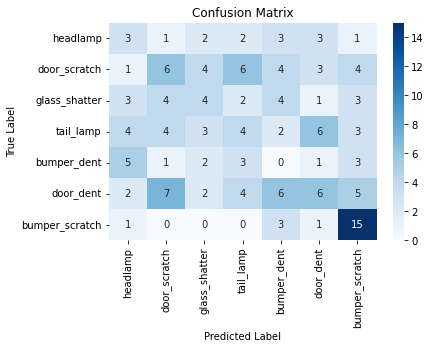

In [18]:
from keras.losses import CategoricalCrossentropy

# define the CNN architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# compile the model
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model on the training data
history = model.fit(gradients_X_train, y_train, epochs=10, batch_size=32, validation_data=(gradients_X_val, y_val))

# evaluate the model on the validation data
val_loss, val_acc = model.evaluate(gradients_X_val, y_val)
print('Validation accuracy:', val_acc)

# evaluate the model on the test data
test_loss, test_acc = model.evaluate(gradients_X_test, y_test)
print('Test accuracy:', test_acc)

# Comparison between Accuracy and epoch for training and validation
plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Save model weights
model.save_weights('model_weights_1.h5')

# VGG16 with adam

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
252/252 [==============================] - 12s 44ms/step - loss: 2.7297 - accuracy: 0.2577 - val_loss: 2.3786 - val_accuracy: 0.2357
Epoch 2/10
252/252 [==============================] - 10s 41ms/step - loss: 1.6954 - accuracy: 0.3237 - val_loss: 1.9618 - val_accuracy: 0.2739
Epoch 3/10
252/252 [==============================] - 10s 41ms/step - loss: 1.5560 - accuracy: 0.3680 - val_loss: 2.0586 - val_accuracy: 0.3121
Epoch 4/10
252/252 [==============================] - 10s 41ms/step - loss: 1.3675 - accuracy: 0.4470 - val_loss: 1.5920 - val_accuracy: 0.3694
Epoch 5/10
252/252 [==============================] - 10s 41ms/step - loss: 1.2038 - accuracy: 0.4931 - val_loss: 1.8469 - val_accuracy: 0.4076
Epoch 6/10
252/252 [==============================] - 10s 42ms/step - loss: 1.0580 - accuracy: 0.5681 - val_loss: 1.9263 - val_accuracy: 0.4650
Epoch 7/10
252/252 [==============================] - 11s 42ms/step - l

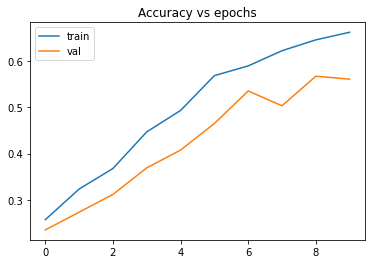

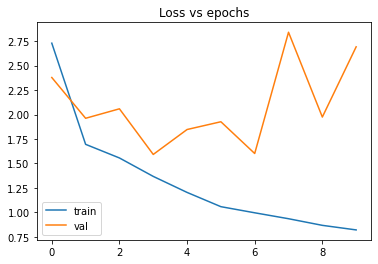

5/5 [==============================] - 0s 39ms/step


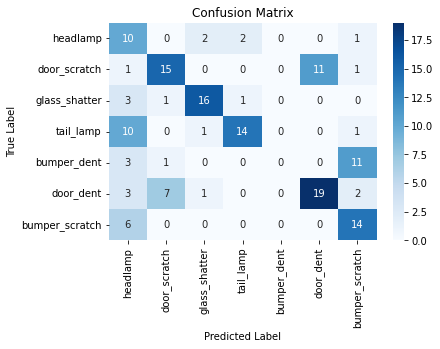

In [19]:
# Load the pre-trained VGG16 model`
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model on the training data
history = model.fit(gradients_X_train, y_train, epochs=10, batch_size=32, validation_data=(gradients_X_val, y_val))

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(gradients_X_val, y_val)
print('Validation accuracy:', val_acc)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(gradients_X_test, y_test)
print('Test accuracy:', test_acc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Save model weights
model.save_weights('model_weights_2.h5')

# VGG16 with SGD 

Epoch 1/10
252/252 [==============================] - 11s 43ms/step - loss: 8.3850 - accuracy: 0.1834 - val_loss: 2.0113 - val_accuracy: 0.1656
Epoch 2/10
252/252 [==============================] - 11s 42ms/step - loss: 2.4404 - accuracy: 0.1880 - val_loss: 2.0071 - val_accuracy: 0.1656
Epoch 3/10
252/252 [==============================] - 11s 42ms/step - loss: 2.1659 - accuracy: 0.1875 - val_loss: 2.0094 - val_accuracy: 0.1656
Epoch 4/10
252/252 [==============================] - 11s 42ms/step - loss: 1.9282 - accuracy: 0.1880 - val_loss: 2.0117 - val_accuracy: 0.1656
Epoch 5/10
252/252 [==============================] - 11s 42ms/step - loss: 1.9263 - accuracy: 0.1880 - val_loss: 2.0099 - val_accuracy: 0.1656
Epoch 6/10
252/252 [==============================] - 11s 43ms/step - loss: 1.9262 - accuracy: 0.1880 - val_loss: 2.0103 - val_accuracy: 0.1656
Epoch 7/10
252/252 [==============================] - 11s 43ms/step - loss: 1.9263 - accuracy: 0.1880 - val_loss: 2.0097 - val_accuracy:

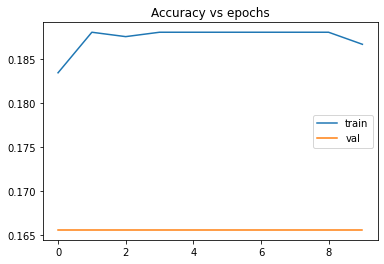

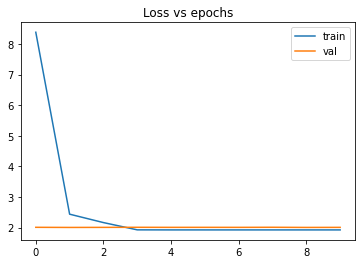

5/5 [==============================] - 0s 40ms/step


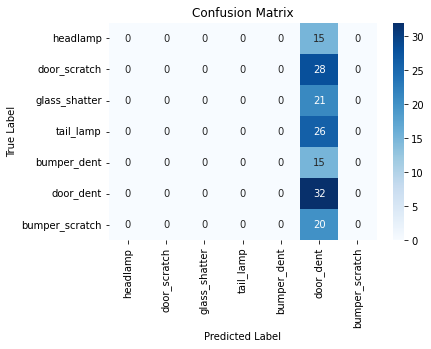

In [20]:
# Load the pre-trained VGG16 model`
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile the model
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model on the training data
history = model.fit(gradients_X_train, y_train, epochs=10, batch_size=32, validation_data=(gradients_X_val, y_val))

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(gradients_X_val, y_val)
print('Validation accuracy:', val_acc)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(gradients_X_test, y_test)
print('Test accuracy:', test_acc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_3.h5')

# VGG16 with RMSprop

Epoch 1/10
252/252 [==============================] - 12s 43ms/step - loss: 5.1604 - accuracy: 0.2517 - val_loss: 3.6419 - val_accuracy: 0.4331
Epoch 2/10
252/252 [==============================] - 11s 42ms/step - loss: 1.8595 - accuracy: 0.4254 - val_loss: 1.8883 - val_accuracy: 0.4522
Epoch 3/10
252/252 [==============================] - 11s 42ms/step - loss: 1.2953 - accuracy: 0.5593 - val_loss: 8.3526 - val_accuracy: 0.5223
Epoch 4/10
252/252 [==============================] - 11s 42ms/step - loss: 1.0346 - accuracy: 0.6624 - val_loss: 2.6011 - val_accuracy: 0.6688
Epoch 5/10
252/252 [==============================] - 11s 43ms/step - loss: 0.8396 - accuracy: 0.7259 - val_loss: 2.7539 - val_accuracy: 0.6943
Epoch 6/10
252/252 [==============================] - 11s 43ms/step - loss: 0.6896 - accuracy: 0.7841 - val_loss: 2.9371 - val_accuracy: 0.6752
Epoch 7/10
252/252 [==============================] - 11s 43ms/step - loss: 0.6020 - accuracy: 0.8232 - val_loss: 3.5829 - val_accuracy:

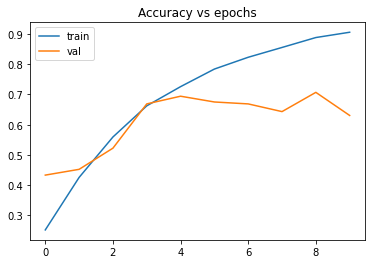

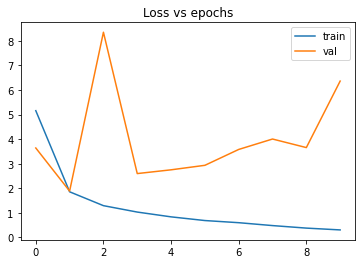

5/5 [==============================] - 0s 39ms/step


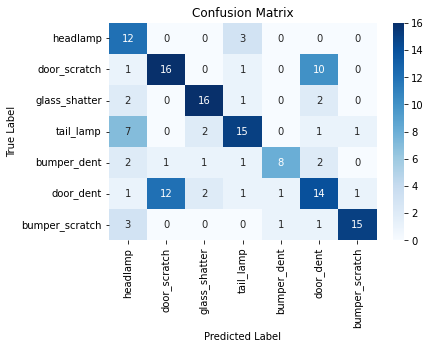

In [21]:
# Load the pre-trained VGG16 model`
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile the model
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=rmsprop, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model on the training data
history = model.fit(gradients_X_train, y_train, epochs=10, batch_size=32, validation_data=(gradients_X_val, y_val))

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(gradients_X_val, y_val)
print('Validation accuracy:', val_acc)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(gradients_X_test, y_test)
print('Test accuracy:', test_acc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Save model weights
model.save_weights('model_weights_4.h5')

# CNN

Epoch 1/50
252/252 [==============================] - 7s 19ms/step - loss: 0.7834 - accuracy: 0.1997 - auc: 0.5852 - val_loss: 0.4311 - val_accuracy: 0.2293 - val_auc: 0.6224
Epoch 2/50
252/252 [==============================] - 4s 17ms/step - loss: 0.3872 - accuracy: 0.3154 - auc: 0.7156 - val_loss: 0.4051 - val_accuracy: 0.2611 - val_auc: 0.6939
Epoch 3/50
252/252 [==============================] - 4s 17ms/step - loss: 0.3384 - accuracy: 0.4498 - auc: 0.8113 - val_loss: 0.4406 - val_accuracy: 0.3439 - val_auc: 0.7029
Epoch 4/50
252/252 [==============================] - 4s 17ms/step - loss: 0.2748 - accuracy: 0.5872 - auc: 0.8933 - val_loss: 0.5275 - val_accuracy: 0.3376 - val_auc: 0.7045
Epoch 5/50
252/252 [==============================] - 4s 17ms/step - loss: 0.2147 - accuracy: 0.7081 - auc: 0.9453 - val_loss: 0.6061 - val_accuracy: 0.3439 - val_auc: 0.7018
Epoch 6/50
252/252 [==============================] - 4s 17ms/step - loss: 0.1650 - accuracy: 0.7998 - auc: 0.9736 - val_loss

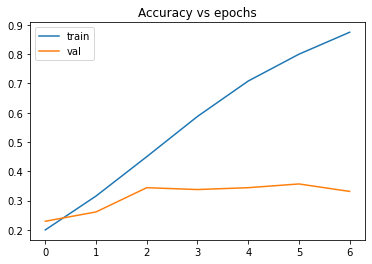

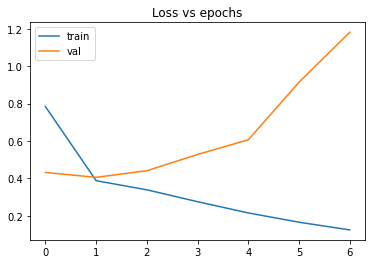

5/5 [==============================] - 0s 5ms/step


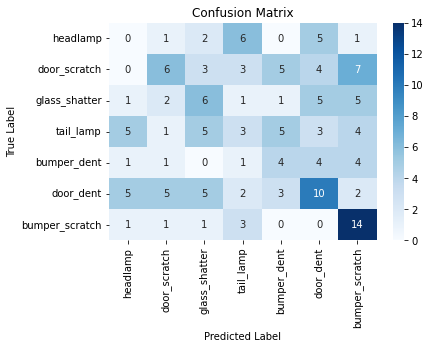

In [22]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, 
    kernel_size=3, activation='relu', 
                    input_shape=(224, 224, 3), padding = "same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, 
    kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, 
    kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(7, activation='softmax')) 

#model.summary()

# train the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])

#model.summary()

history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_5.h5')

# EfficientNetB4 with adam

71892840/71892840 [==============================] - 1s 0us/step
Epoch 1/50
252/252 [==============================] - 122s 294ms/step - loss: 0.1371 - accuracy: 0.8138 - auc: 0.9683 - val_loss: 0.3622 - val_accuracy: 0.6752 - val_auc: 0.8897
Epoch 2/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0497 - accuracy: 0.9407 - auc: 0.9913 - val_loss: 0.2946 - val_accuracy: 0.8025 - val_auc: 0.9063
Epoch 3/50
252/252 [==============================] - 71s 281ms/step - loss: 0.0383 - accuracy: 0.9555 - auc: 0.9927 - val_loss: 0.2259 - val_accuracy: 0.8153 - val_auc: 0.9309
Epoch 4/50
252/252 [==============================] - 71s 281ms/step - loss: 0.0233 - accuracy: 0.9735 - auc: 0.9961 - val_loss: 0.2292 - val_accuracy: 0.7898 - val_auc: 0.9264
Epoch 5/50
252/252 [==============================] - 71s 281ms/step - loss: 0.0255 - accuracy: 0.9739 - auc: 0.9954 - val_loss: 0.3286 - val_accuracy: 0.7516 - val_auc: 0.8960
Epoch 6/50
252/252 [=============================

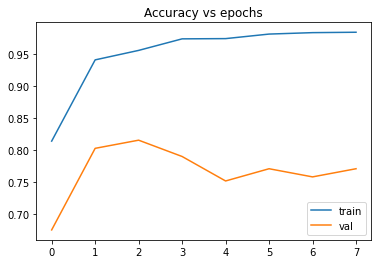

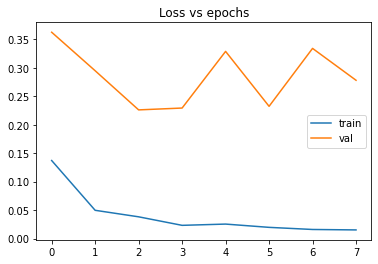

5/5 [==============================] - 2s 58ms/step


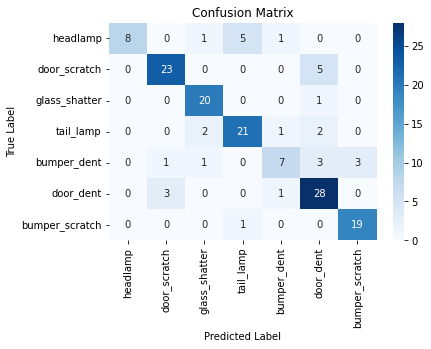

In [23]:
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= 'relu'), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)

#model2.summary()

#model2.fit(train_generator, epochs=2, validation_data=validation_generator)

history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_6.h5')

# EfficientNetB4 with SGD

Epoch 1/50
252/252 [==============================] - 94s 284ms/step - loss: 0.7734 - accuracy: 0.7174 - auc: 0.9510 - val_loss: 0.7140 - val_accuracy: 0.7962 - val_auc: 0.9613
Epoch 2/50
252/252 [==============================] - 70s 278ms/step - loss: 0.0861 - accuracy: 0.9716 - auc: 0.9991 - val_loss: 0.6694 - val_accuracy: 0.8217 - val_auc: 0.9672
Epoch 3/50
252/252 [==============================] - 71s 280ms/step - loss: 0.0434 - accuracy: 0.9856 - auc: 0.9997 - val_loss: 0.6624 - val_accuracy: 0.8344 - val_auc: 0.9676
Epoch 4/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0321 - accuracy: 0.9902 - auc: 0.9998 - val_loss: 0.6902 - val_accuracy: 0.8408 - val_auc: 0.9620
Epoch 5/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0211 - accuracy: 0.9938 - auc: 0.9998 - val_loss: 0.7867 - val_accuracy: 0.8408 - val_auc: 0.9656
Epoch 6/50
252/252 [==============================] - 70s 280ms/step - loss: 0.0145 - accuracy: 0.9956 - auc: 0.999

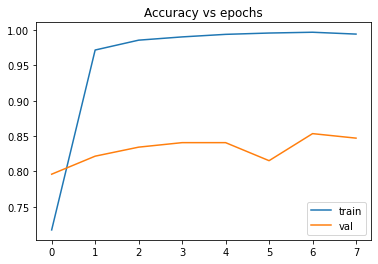

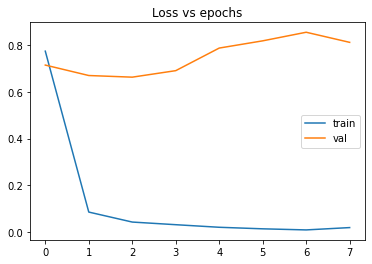

5/5 [==============================] - 2s 58ms/step


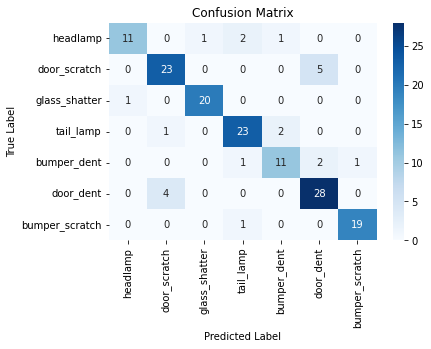

In [24]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.9),
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_7.h5')

# EfficientNetB4 with RMSprop

Epoch 1/50
252/252 [==============================] - 109s 284ms/step - loss: 0.5966 - accuracy: 0.8006 - auc: 0.9686 - val_loss: 3.2611 - val_accuracy: 0.5541 - val_auc: 0.7868
Epoch 2/50
252/252 [==============================] - 70s 279ms/step - loss: 0.2487 - accuracy: 0.9231 - auc: 0.9919 - val_loss: 2.1417 - val_accuracy: 0.6815 - val_auc: 0.8890
Epoch 3/50
252/252 [==============================] - 70s 278ms/step - loss: 0.1501 - accuracy: 0.9552 - auc: 0.9961 - val_loss: 1.1634 - val_accuracy: 0.8280 - val_auc: 0.9377
Epoch 4/50
252/252 [==============================] - 70s 280ms/step - loss: 0.1291 - accuracy: 0.9627 - auc: 0.9960 - val_loss: 0.8138 - val_accuracy: 0.8025 - val_auc: 0.9598
Epoch 5/50
252/252 [==============================] - 70s 277ms/step - loss: 0.0884 - accuracy: 0.9726 - auc: 0.9978 - val_loss: 1.2221 - val_accuracy: 0.8280 - val_auc: 0.9440
Epoch 6/50
252/252 [==============================] - 71s 280ms/step - loss: 0.0865 - accuracy: 0.9754 - auc: 0.99

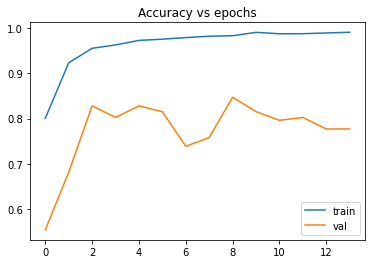

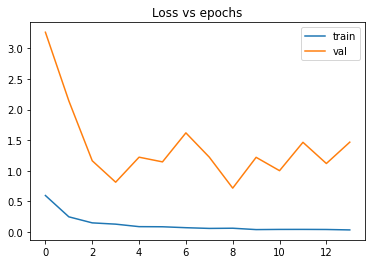

5/5 [==============================] - 2s 58ms/step


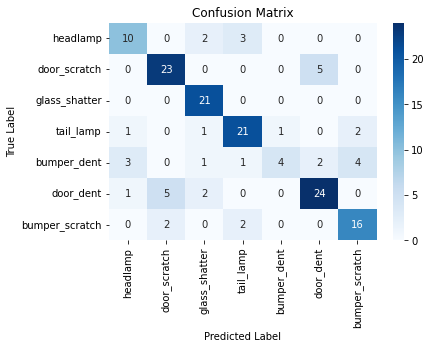

In [25]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)

model.compile(
    optimizer=rmsprop,
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_8.h5')

# Sobel Operator with EfficientNetB4(SGD)

In [26]:
# # Apply the Sobel operator to each image in the array
gradients_X_train = np.array([apply_sobel_3c(image) for image in X_train])
gradients_X_test = np.array([apply_sobel_3c(image) for image in X_test])
gradients_X_val = np.array([apply_sobel_3c(image) for image in X_val])
# # 77%

Epoch 1/50
252/252 [==============================] - 92s 285ms/step - loss: 0.7337 - accuracy: 0.7352 - auc: 0.9566 - val_loss: 0.7279 - val_accuracy: 0.8089 - val_auc: 0.9536
Epoch 2/50
252/252 [==============================] - 70s 278ms/step - loss: 0.0805 - accuracy: 0.9741 - auc: 0.9991 - val_loss: 0.5253 - val_accuracy: 0.8662 - val_auc: 0.9744
Epoch 3/50
252/252 [==============================] - 71s 280ms/step - loss: 0.0502 - accuracy: 0.9830 - auc: 0.9996 - val_loss: 0.6955 - val_accuracy: 0.8471 - val_auc: 0.9589
Epoch 4/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0322 - accuracy: 0.9896 - auc: 0.9996 - val_loss: 0.5881 - val_accuracy: 0.8471 - val_auc: 0.9689
Epoch 5/50
252/252 [==============================] - 71s 281ms/step - loss: 0.0158 - accuracy: 0.9954 - auc: 0.9998 - val_loss: 0.7093 - val_accuracy: 0.8408 - val_auc: 0.9618
Epoch 6/50
252/252 [==============================] - 71s 280ms/step - loss: 0.0171 - accuracy: 0.9944 - auc: 0.999

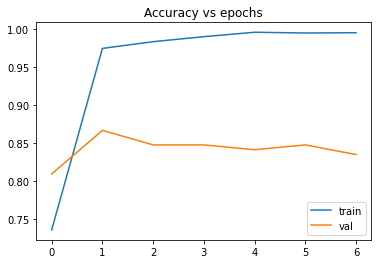

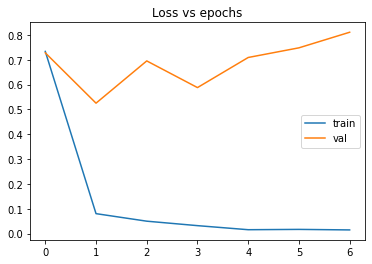

5/5 [==============================] - 2s 58ms/step


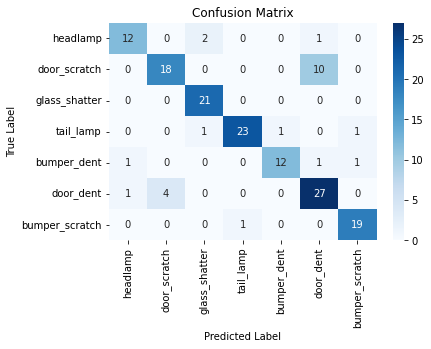

In [27]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.9),
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_9.h5')

# Canny Operator with EfficientNetB4(SGD)

In [28]:
# Apply Canny edge detection with minimum threshold of 100 and maximum threshold of 200
gradients_X_train = np.array([apply_canny(image,100, 200) for image in X_train])
gradients_X_test = np.array([apply_canny(image,100, 200) for image in X_test])
gradients_X_val = np.array([apply_canny(image,100, 200) for image in X_val])
# 69%

Epoch 1/50
252/252 [==============================] - 93s 285ms/step - loss: 1.0962 - accuracy: 0.5809 - auc: 0.8982 - val_loss: 0.7263 - val_accuracy: 0.7197 - val_auc: 0.9530
Epoch 2/50
252/252 [==============================] - 70s 277ms/step - loss: 0.3458 - accuracy: 0.8797 - auc: 0.9888 - val_loss: 0.9269 - val_accuracy: 0.7134 - val_auc: 0.9374
Epoch 3/50
252/252 [==============================] - 70s 278ms/step - loss: 0.1556 - accuracy: 0.9500 - auc: 0.9971 - val_loss: 0.8795 - val_accuracy: 0.7452 - val_auc: 0.9520
Epoch 4/50
252/252 [==============================] - 70s 277ms/step - loss: 0.0977 - accuracy: 0.9682 - auc: 0.9986 - val_loss: 1.0550 - val_accuracy: 0.7516 - val_auc: 0.9450
Epoch 5/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0646 - accuracy: 0.9779 - auc: 0.9992 - val_loss: 1.0888 - val_accuracy: 0.7643 - val_auc: 0.9337
Epoch 6/50
5/5 [==============================] - 0s 59ms/step - loss: 1.2969 - accuracy: 0.7643 - auc: 0.9273
Test

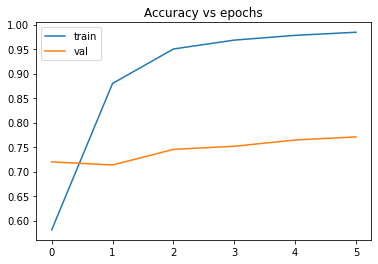

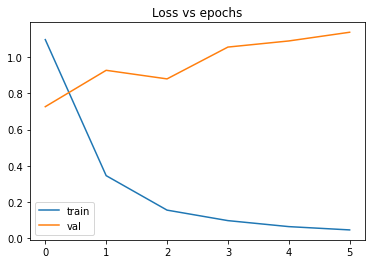

5/5 [==============================] - 2s 56ms/step


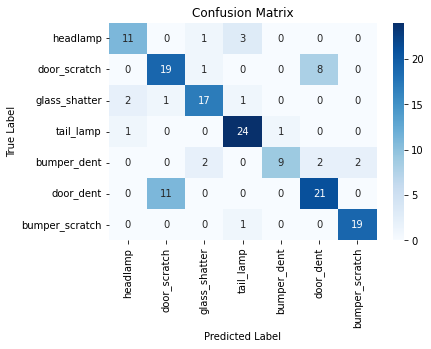

In [29]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.9),
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_10.h5')

# Harris Operator with EfficientNetB4(SGD)

In [30]:
# Set the block size and Sobel kernel size
block_size = 2
ksize = 3

# Set the Harris detector parameter
k = 0.04

# Apply the Harris corner detector
gradients_X_train = np.array([apply_harris(image, block_size, ksize, k) for image in X_train])
gradients_X_test = np.array([apply_harris(image, block_size, ksize, k) for image in X_test])
gradients_X_val = np.array([apply_harris(image, block_size, ksize, k) for image in X_val])
# 49%

Epoch 1/50
252/252 [==============================] - 91s 282ms/step - loss: 1.3480 - accuracy: 0.4784 - auc: 0.8394 - val_loss: 1.1720 - val_accuracy: 0.6497 - val_auc: 0.8888
Epoch 2/50
252/252 [==============================] - 70s 277ms/step - loss: 0.4587 - accuracy: 0.8358 - auc: 0.9813 - val_loss: 1.2142 - val_accuracy: 0.5924 - val_auc: 0.9076
Epoch 3/50
252/252 [==============================] - 70s 277ms/step - loss: 0.1655 - accuracy: 0.9438 - auc: 0.9969 - val_loss: 1.5013 - val_accuracy: 0.6561 - val_auc: 0.9018
Epoch 4/50
252/252 [==============================] - 69s 275ms/step - loss: 0.0984 - accuracy: 0.9684 - auc: 0.9984 - val_loss: 1.6148 - val_accuracy: 0.6306 - val_auc: 0.8881
Epoch 5/50
252/252 [==============================] - 70s 277ms/step - loss: 0.0811 - accuracy: 0.9743 - auc: 0.9985 - val_loss: 1.3178 - val_accuracy: 0.6688 - val_auc: 0.9200
Epoch 6/50
5/5 [==============================] - 0s 59ms/step - loss: 1.4216 - accuracy: 0.6943 - auc: 0.9109
Test

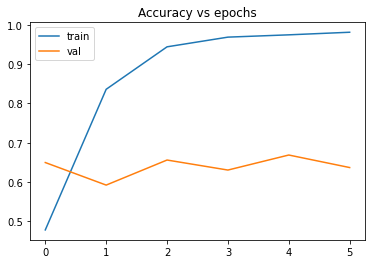

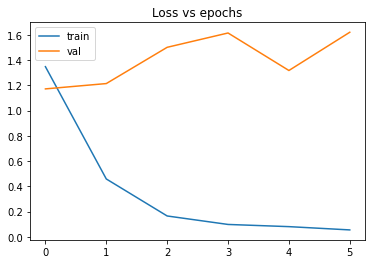

5/5 [==============================] - 2s 57ms/step


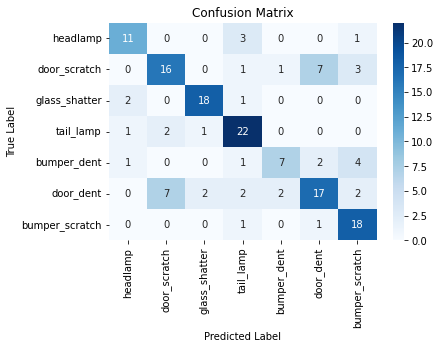

In [31]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.9),
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_11.h5')

# LBP Operator with EfficientNetB4(SGD)

In [32]:

# Apply LBP
gradients_X_train = np.array([apply_lbp(image) for image in X_train])
gradients_X_test = np.array([apply_lbp(image) for image in X_test])
gradients_X_val = np.array([apply_lbp(image) for image in X_val])
# 77%

Epoch 1/50
252/252 [==============================] - 92s 282ms/step - loss: 0.9711 - accuracy: 0.6456 - auc: 0.9197 - val_loss: 0.6237 - val_accuracy: 0.7834 - val_auc: 0.9651
Epoch 2/50
252/252 [==============================] - 70s 278ms/step - loss: 0.1686 - accuracy: 0.9438 - auc: 0.9969 - val_loss: 0.8256 - val_accuracy: 0.7834 - val_auc: 0.9524
Epoch 3/50
252/252 [==============================] - 70s 279ms/step - loss: 0.0742 - accuracy: 0.9769 - auc: 0.9985 - val_loss: 1.1236 - val_accuracy: 0.7643 - val_auc: 0.9383
Epoch 4/50
252/252 [==============================] - 70s 278ms/step - loss: 0.0451 - accuracy: 0.9856 - auc: 0.9997 - val_loss: 1.0044 - val_accuracy: 0.7771 - val_auc: 0.9430
Epoch 5/50
252/252 [==============================] - 70s 278ms/step - loss: 0.0317 - accuracy: 0.9893 - auc: 0.9997 - val_loss: 1.0424 - val_accuracy: 0.7834 - val_auc: 0.9543
Epoch 6/50
5/5 [==============================] - 0s 59ms/step - loss: 1.1409 - accuracy: 0.7643 - auc: 0.9241
Test

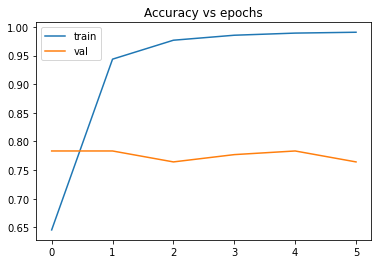

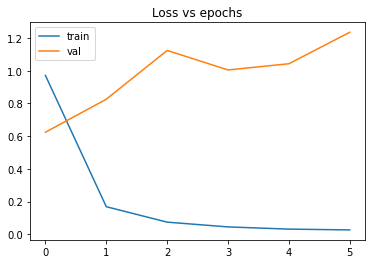

5/5 [==============================] - 2s 57ms/step


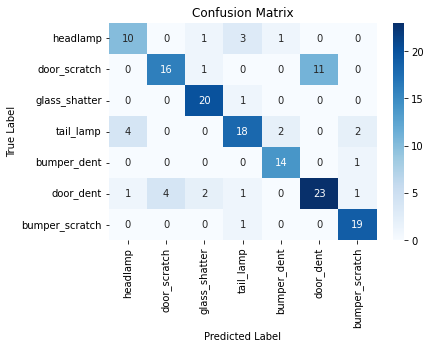

In [33]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

from keras.losses import categorical_crossentropy

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.9),
    loss=categorical_crossentropy,
    metrics=['accuracy','AUC']
)


history = model.fit(gradients_X_train, y_train,
            batch_size=32,
            epochs=50,
            verbose=1,
            validation_data=(gradients_X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping(patience=5))
 
loss, accuracy, auc = model.evaluate(gradients_X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

plt.title('Accuracy vs epochs')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

# Comparison between Loss and epoch for training and validation
plt.title('Loss vs epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

y_true = np.argmax(y_test, axis=1)

# make predictions on new data
y_pred = np.argmax(model.predict(gradients_X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["headlamp","door_scratch","glass_shatter","tail_lamp","bumper_dent","door_dent","bumper_scratch"]
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Save model weights
model.save_weights('model_weights_12.h5')

# Final Model with best accuracy Laplacian Operator with EfficientNetB4(SGD)

In [5]:
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(7, activation='softmax')
])

# Load the saved weights
model.load_weights('model_weights_7.h5')

# Load an image
img = cv2.imread('2.jpeg')
img = cv2.resize(img, (224, 224))
img = np.array(img)
gradients_X = np.array(apply_laplacian(img))
# Make a prediction on the image
gradients_X = np.expand_dims(gradients_X, axis=0)
preds = model.predict(gradients_X)
predicted_class = np.argmax(preds)

# Print the predicted class
print(f"Predicted class: {predicted_class}")



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
1/1 [==============================] - 3s 3s/step
Predicted class: 1
